# Plot individual images on the cluster

This notebook enables up to view raster outputs (.tif and .nc) on the cluster without needing to transfer files

## Imports

In [5]:
import os
import sys
import ipywidgets as widgets #not really using right now
from functools import partial #not really using right now
from IPython.display import Image
%matplotlib inline

In [6]:
sys.path.append(r"../LUCinSA_helpers")
from file_info import *
from file_checks import *
from plot import *

In [7]:
class Counter:
    def __init__(self, initial=0):
        self.value = initial
    def increment(self, amount=1):
        self.value += amount
        print(self.value)
        return self.value
    def __iter__(self, sentinal=False):
        return iter(self.increment, sentinal)

In [8]:
'''
PARAMETERS: modify in Notebook_settings notebook, then run that notebook and this cell to update here
DO not modify this cell
'''

%store -r basic_config
print("Basic Parameters: \n PrintDate = {} \n brdf_dir = {} \n data source = {} \n gridCell = {} \n index_dir = {} \n out_dir = {}"
      .format(basic_config['today'],basic_config['brdf_dir'],basic_config['data_source'],basic_config['grid_cell'],basic_config['index_dir'],basic_config['out_dir']))

%store -r single_plot_params
print("Plotting Parameters: \n Viewband = {} \n imageType = {} \n plotYr = {} \n plotDay = {}"
      .format(single_plot_params['viewband'],single_plot_params['image_type'],single_plot_params['plot_yr'],single_plot_params['plot_day']))

Basic Parameters: 
 PrintDate = 2023-08-20 
 brdf_dir = /home/sandbox-cel/paraguay_lc/stac/grid/003773/brdf 
 data source = stac 
 gridCell = 3773 
 index_dir = /home/downspout-cel/paraguay_lc/stac/grids/003773/brdf_ts/ms/ndmi 
 out_dir = /home/klwalker/data/tmp
Plotting Parameters: 
 Viewband = nir 
 imageType = AllRaw 
 plotYr = 2021 
 plotDay = 100


In [9]:
print('closest downloaded Sentinel image is:')
samp_img_raw_sentinel = get_closest_image(os.path.join(basic_config['raw_dir'],'{:06d}'.format(basic_config['grid_cell'])), 'Sentinel', basic_config['data_source'], single_plot_params['plot_yr'], single_plot_params['plot_day'])
print('closest Sentinel brdf is:')
samp_img_brdf_sentinel = get_closest_image(basic_config['brdf_dir'], 'Sentinel', basic_config['data_source'], single_plot_params['plot_yr'], single_plot_params['plot_day'])
print('closest downloaded Landsat image is:')
samp_img_raw_landsat = get_closest_image(os.path.join(basic_config['raw_dir'],'{:06d}'.format(basic_config['grid_cell'])), 'Landsat', basic_config['data_source'], single_plot_params['plot_yr'], single_plot_params['plot_day'])
print('closest downloaded Landsat5 image is:')
samp_img_raw_landsat5 = get_closest_image(os.path.join(basic_config['raw_dir'],'{:06d}'.format(basic_config['grid_cell'])), 'Landsat5', basic_config['data_source'], single_plot_params['plot_yr'], single_plot_params['plot_day'])
print('closest downloaded Landsat7 image is:')
samp_img_raw_landsat7 = get_closest_image(os.path.join(basic_config['raw_dir'],'{:06d}'.format(basic_config['grid_cell'])), 'Landsat7', basic_config['data_source'], single_plot_params['plot_yr'], single_plot_params['plot_day'])
print('closest downloaded Landsat8 image is:')
samp_img_raw_landsat8 = get_closest_image(os.path.join(basic_config['raw_dir'],'{:06d}'.format(basic_config['grid_cell'])), 'Landsat8', basic_config['data_source'], single_plot_params['plot_yr'], single_plot_params['plot_day'])
print('closest downloaded Landsat9 image is:')
samp_img_raw_landsat9 = get_closest_image(os.path.join(basic_config['raw_dir'],'{:06d}'.format(basic_config['grid_cell'])), 'Landsat9', basic_config['data_source'], single_plot_params['plot_yr'], single_plot_params['plot_day'])
print('closest Landsat brdf is:')
samp_img_brdf_landsat = get_closest_image(basic_config['brdf_dir'], 'Landsat', basic_config['data_source'],single_plot_params['plot_yr'], single_plot_params['plot_day'])
print('closest smoothed {} index image is:'.format(basic_config['spec_index']))
samp_img_smooth = get_closest_image(basic_config['index_dir'], 'Smooth', basic_config['data_source'], single_plot_params['plot_yr'], single_plot_params['plot_day'])

closest downloaded Sentinel image is:
     there are no Sentinel images for target year 2021
closest Sentinel brdf is:
/home/sandbox-cel/paraguay_lc/stac/grid/003773/brdf/L3B_S2B_brdf21JWL0L2A_20210408_20230210_C01_coreg.nc with file size 28517113
closest downloaded Landsat image is:
     there are no Landsat images for target year 2021
closest downloaded Landsat5 image is:
     there are no Landsat5 images for target year 2021
closest downloaded Landsat7 image is:
     there are no Landsat7 images for target year 2021
closest downloaded Landsat8 image is:
     there are no Landsat8 images for target year 2021
closest downloaded Landsat9 image is:
     there are no Landsat9 images for target year 2021
closest Landsat brdf is:
/home/sandbox-cel/paraguay_lc/stac/grid/003773/brdf/L3A_LC08_brdf22507802T1_20210410_20230210_C01.nc with file size 28291824
closest smoothed ndmi index image is:
/home/downspout-cel/paraguay_lc/stac/grids/003773/brdf_ts/ms/ndmi/2021100.tif
/home/downspout-cel/par

plotting nir band of image /home/sandbox-cel/paraguay_lc/stac/grid/003773/brdf/L3B_S2B_brdf21JWL0L2A_20210408_20230210_C01_coreg.nc
this is in .nc format
epsg:8858
['blue', 'green', 'nir', 'red', 'swir1', 'swir2']
Coord range is: y: -3359710.0--3339500.0. x: 3018730.0-3038940.0
The no data value is: nan


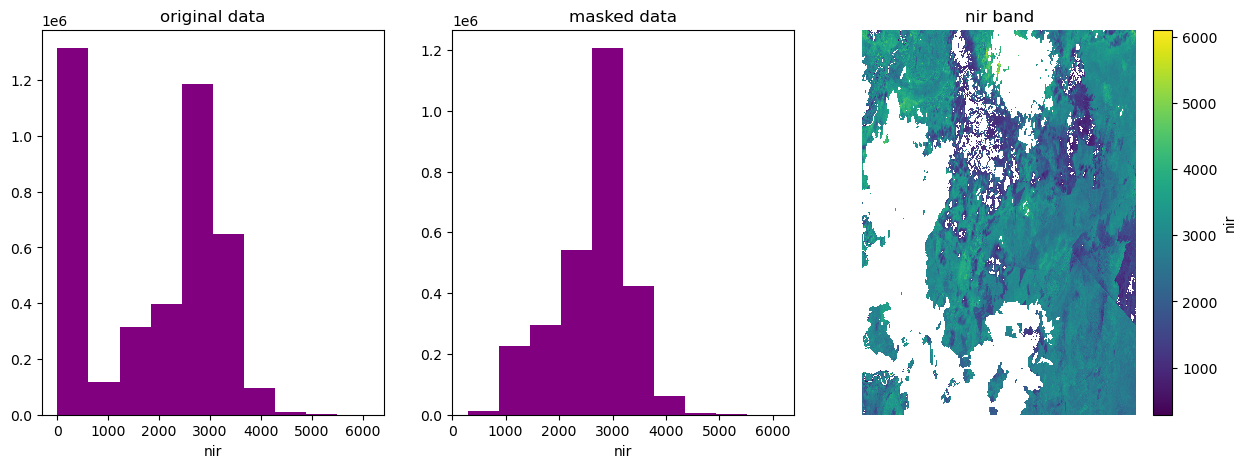

In [10]:
if single_plot_params['image_type'] == 'Smooth':
    #get_valid_pix_per(samp_img_smooth)
    explore_band(samp_img_smooth, basic_config['spec_index'])
elif single_plot_params['image_type'] in ['Sentinel','AllRaw']:
    #get_valid_pix_per(samp_img_brdf_sentinel)
    explore_band(samp_img_brdf_sentinel, single_plot_params['viewband'])
elif single_plot_params['image_type'] == 'Landsat':
    #get_valid_pix_per(samp_img_brdf_landsat)
    explore_band(samp_img_brdf_landsat, single_plot_params['viewband'])

plotting nir band of image None


AttributeError: 'NoneType' object has no attribute 'endswith'

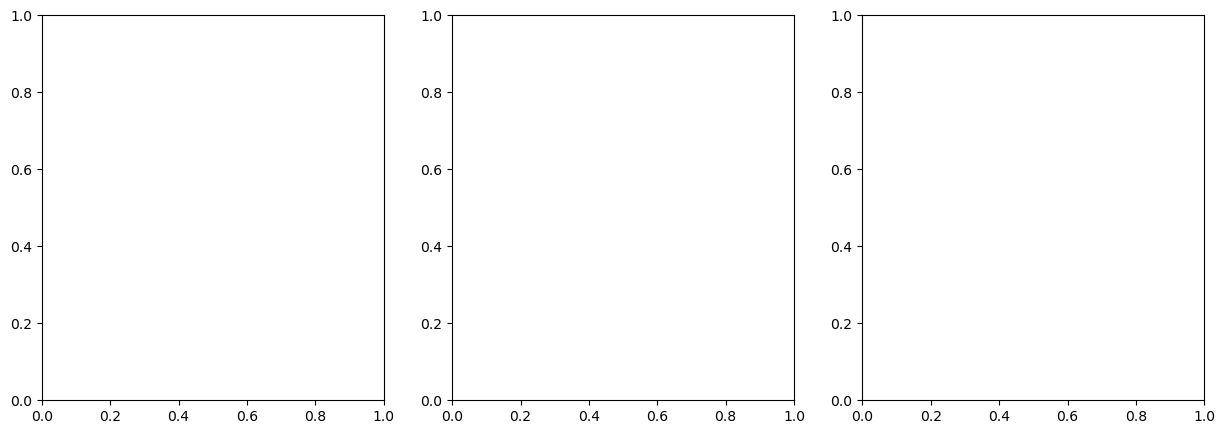

In [11]:
explore_band(samp_img_raw_sentinel, single_plot_params['viewband']);

plotting nir band of image None


AttributeError: 'NoneType' object has no attribute 'endswith'

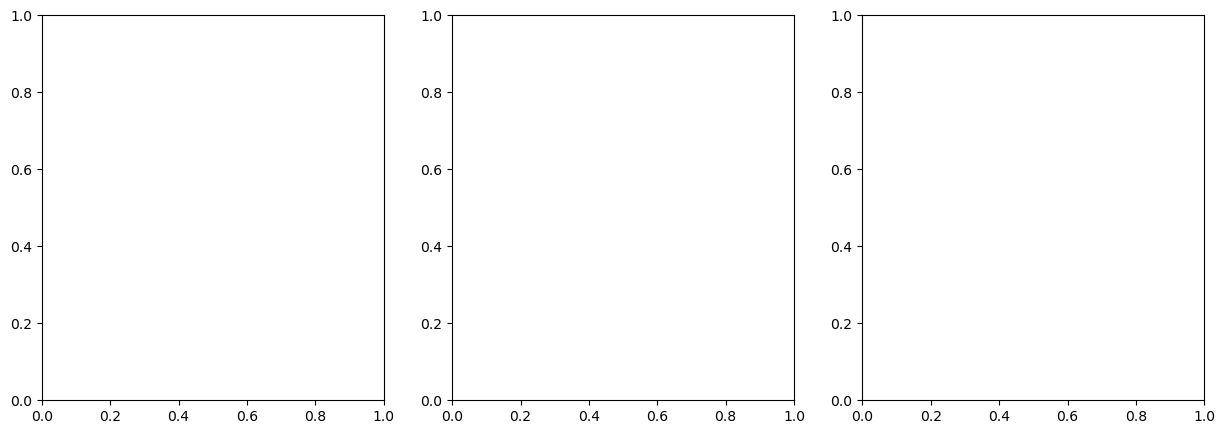

In [12]:
explore_band(samp_img_raw_landsat, single_plot_params['viewband']);

## Plot 3-band image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


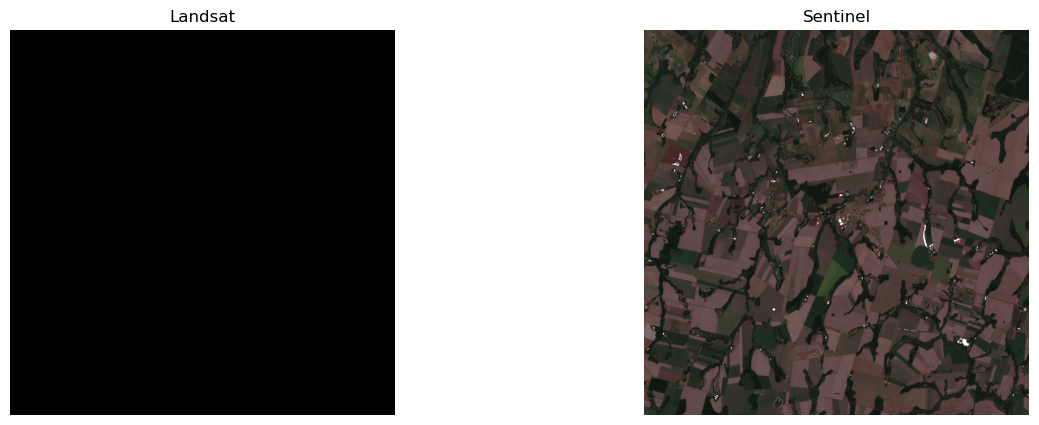

In [7]:
fig, axarr = plt.subplots(1, 2, figsize=(15,5))
l_rgb = get_rbg_img(samp_img_raw_landsat,single_plot_params['gamma'])
axarr[0].imshow(l_rgb)
axarr[0].set_title("Landsat")
axarr[0].axis('off')
s_rgb = get_rbg_img(samp_img_raw_sentinel,single_plot_params['gamma'])
axarr[1].imshow(s_rgb)
axarr[1].set_title("Sentinel")
axarr[1].axis('off');

In [ ]:
def button_iterater(counter, w):
    counter.increment()    

counter = Counter()
w = widgets.Button(description='Next')
w.on_click(partial(button_iterater, counter))
display(w)

In [ ]:
l_rgb = get_rbg_img(samp_img_raw_landsat,single_plot_params['gamma'])
fig = plt.figure(figsize=(18,12))
plt.imshow(l_rgb)
plt.title("Landsat")
plt.axis('off');

## Compare original, downloaded and brdf image:

In [ ]:
l_orig_id = os.path.basename(samp_img_raw_landsat).strip('.tif')
l_orig = get_img_from_planetary_hub(l_orig_id)
Image(url=l_orig.assets["rendered_preview"].href, width=500)

In [ ]:
fig, axarr = plt.subplots(2, 2, figsize=(10,10))
l_dl = get_rbg_img(samp_img_raw_landsat,single_plot_params['gamma'])
l_brdf = get_rbg_img(samp_img_brdf_landsat,single_plot_params['gamma'])
s_dl = get_rbg_img(samp_img_raw_sentinel,single_plot_params['gamma'])
s_brdf = get_rbg_img(samp_img_brdf_sentinel,single_plot_params['gamma'])

axarr[0,0].imshow(l_dl)
axarr[0,0].set_title("original Landsat download")
axarr[0,0].axis('off')
axarr[0,1].imshow(l_brdf)
axarr[0,1].set_title("Landsat brdf")
axarr[0,1].axis('off')
axarr[1,0].imshow(s_dl)
axarr[1,0].set_title("original Sentinel download")
axarr[1,0].axis('off')
axarr[1,1].imshow(s_brdf)
axarr[1,1].set_title("Sentinel brdf")
axarr[1,1].axis('off');

## Iterate through images with button (not really using at moment)

In [ ]:
imgs = [f for f in os.listdir(basic_config['brdf_dir']) if f.endswith(tuple(['.nc','tif'])) and 'X.nc' not in f]
def button_iterater(counter, w):
    counter.increment()  
def iterate_images(counter, w):
    counter.increment() 
    img = get_rbg_img(os.path.join(basic_config['brdf_dir'],imgs[counter.value]),single_plot_params['gamma'])
    fig = plt.figure(figsize=(7,5))
    plt.imshow(img)
                                                      
counter = Counter()
w = widgets.Button(description='Next image')
w.on_click(partial(iterate_images, counter))
display(w)

# make / view thumbnails for all images in directory

In [11]:
yrs = str(single_plot_params['plot_yr'])
#if single_plot_params['image_type'] == 'AllRaw':
img_dir = basic_config['brdf_dir']
thumbnail_dir = os.path.join(basic_config['raw_dir'],'{:06d}'.format(basic_config['grid_cell']), 'thumbnails','brdf')
exclude='X.nc'
include=None
out_file = "./Outputs/img_thumbnails/{}_brdf_{}.png".format(basic_config['grid_cell'], yrs)
view_thumbnails(img_dir,thumbnail_dir,out_file,single_plot_params['gamma'],exclude,include,yrs,reduct_factor=10)

# view images that failed to coregister:

In [ ]:
#yrs = str(single_plot_params['plot_yr'])
yrs = None
img_dir = basic_config['brdf_dir']
thumbnail_dir = os.path.join(basic_config['raw_dir'],'{:06d}'.format(basic_config['grid_cell']), 'thumbnails','brdf')
exclude=None
include='X.nc'
out_file = "./Outputs/img_thumbnails/{}_failed_coreg_{}.png".format(basic_config['grid_cell'], yrs)
view_thumbnails(img_dir,thumbnail_dir,out_file,single_plot_params['gamma'],exclude,include,yrs,reduct_factor=10)

# File checks -- more complete in other notebooks

In [ ]:
## Slice processing database by start and end years in parameters

processing_db = read_db(os.path.join(basic_config['raw_dir'],'{:06d}'.format(basic_config['grid_cell']),'processing.info'), db_version='current')
processing_db['date'] = pd.to_datetime(processing_db['date'], format='%Y%m%d', errors='coerce').dt.date

start = datetime.datetime.strptime('{}-01-01'.format(single_plot_params['plot_yr']),'%Y-%m-%d').date()
end = datetime.datetime.strptime('{}-12-31'.format(single_plot_params['plot_yr']),'%Y-%m-%d').date()
dfslice = processing_db[(processing_db['date'] > start) & (processing_db['date'] < end)]

## can set date to index
#dfslice.reset_index(inplace=True)
#dfslice.set_index(['date'], inplace=True, drop=True)
#dfslice = dfslice.rename_axis(None)

dfslice.head(n=5)

In [ ]:
### Make valid pixel db for brdf and orig images
##  NOTE: THis can be heavy and best run through Slurm with the .sh script and then loaded as below
## NOTE: all of this needs modification to work with current processing db. ValidPix noted at download, so part of the work can be pulled straight from the db 
#valid_pixdb = check_valid_pixels(basic_config['raw_dir'],basic_config['brdf_dir'],basic_config['grid_cell'],'Landsat8',yrs=[2021,2021],data_source='stac')
'''
brdf_file_list = dfslice['brdf_id'].tolist()
dl_file_list = dfslice['dl'].tolist()
#print('There are {} files in file list'.format(len(brdf_file_list)))
time_names = dfslice.date.dt.strftime('%Y-%m-%d').values.tolist()
validpix_brdf = get_num_valid_pix_for_stac(brdf_file_list)
validpix_orig = get_num_valid_pix_for_stac(dl_file_list, date_list=time_names)

fig, axarr = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Num valid pixels for {}'.format(single_plot_params['plot_yr']))
rawim = axarr[0].imshow(validpix_orig, cmap='jet_r')
axarr[0].set_title("original downloads")
bimg = axarr[1].imshow(validpix_brdf, cmap='jet_r')
axarr[1].set_title("brdfs")
fig.colorbar(rawim, ax=axarr[0], fraction=0.046, pad=0.04) 
fig.colorbar(bimg, ax=axarr[1], fraction=0.046, pad=0.04) ;
'''

## To save an html copy of this notebook with all outputs:

In [ ]:
### Run to print output as html

out_name = str(basic_config['country']+'1b_ExploreData_OpenImage'+str(basic_config['grid_cell'])+'_from_'+str(single_plot_params['plot_yr'])+str(single_plot_params['plot_day']))
!jupyter nbconvert --output-dir='./Outputs' --to html --no-input --output=$out_name 1b_ExploreData_OpenImage.ipynb